## 1. Getting Data

In [7]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision

    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular.
    !mv pytorch-deep-learning/helper_functions.py.  # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [10]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [11]:
# setup training and test path

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment

## 3. EffNetB2

```import torchvision
# 1. setup pretrained effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()
# 3. setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="Default"
# 4. freeze the base layer in the model
for param in effnetb2.parameters():
    param.requires_grad = False
# 5. set classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [12]:
def creat_effnetb2_model(num_classes: int = 3,
                         seed: int = 42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

In [13]:
effnetb2, effnetb2_transforms = creat_effnetb2_model(num_classes=3, seed=42)

In [14]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 test_transform=effnetb2_transforms,
                                                                                                 batch_size=32,
                                                                                                 num_workers=0)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [17]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9791 | train_acc: 0.5729 | test_loss: 0.7367 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.7109 | train_acc: 0.8583 | test_loss: 0.5853 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5903 | train_acc: 0.8896 | test_loss: 0.4856 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4504 | train_acc: 0.9042 | test_loss: 0.4317 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4316 | train_acc: 0.8958 | test_loss: 0.3888 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4412 | train_acc: 0.8792 | test_loss: 0.3478 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4319 | train_acc: 0.8771 | test_loss: 0.3224 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3903 | train_acc: 0.8979 | test_loss: 0.3423 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3747 | train_acc: 0.8938 | test_loss: 0.3101 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3657 | train_acc: 0.8667 | test_loss: 0.2781 | test_acc: 0.9625


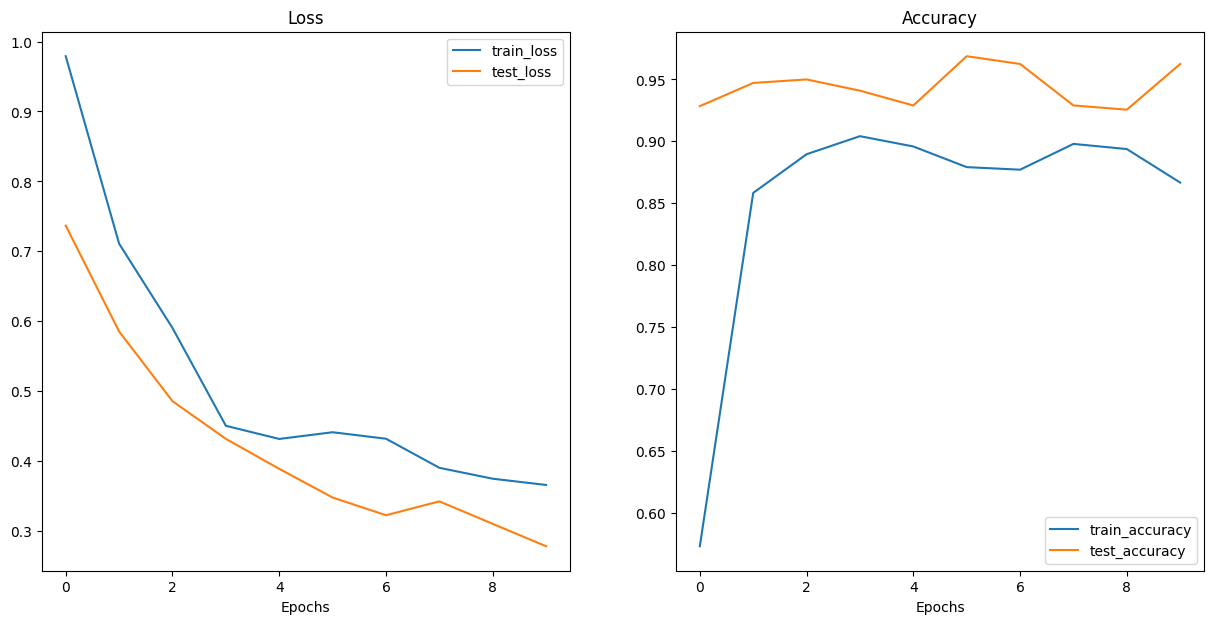

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [19]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth


Size

In [20]:
from pathlib import Path

pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EFFNET_B2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)}MB")

Pretrained EFFNET_B2 feature extractor model size: 29.86MB


Number of Parameters

In [21]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
effnetb2_state = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426}

# ViT Extractor

In [18]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    return model, transforms

In [20]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [21]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32,
                                                                                       num_workers=0)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [22]:
from going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [23]:
device

'cuda'

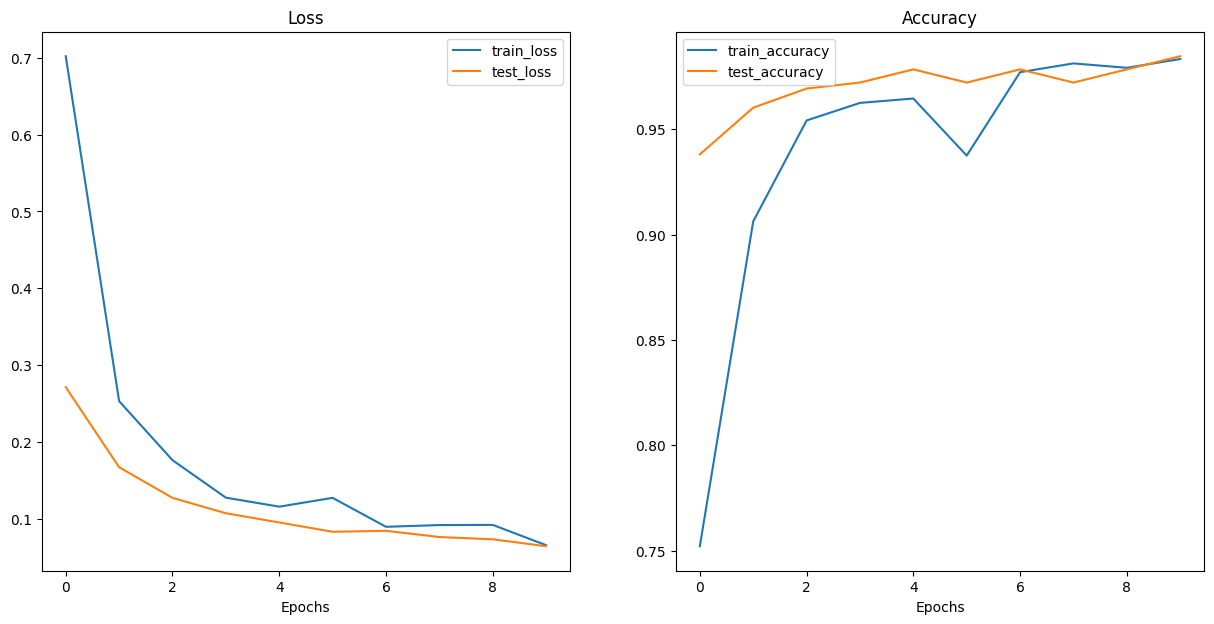

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [25]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth")


[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth


In [26]:
from pathlib import Path

pretrained_vit_model_size = Path(
    "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)}MB")

Pretrained vit feature extractor model size: 327.37MB


In [27]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [28]:
vit_state = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_state

{'test_loss': 0.06443451354280114,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175}

In [29]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [30]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    for path in tqdm(paths):
        pred_dict = {"image_path": path}
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            ent_time = timer()
            pred_dict["time_for_pred"] = round(ent_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list


In [31]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9943,
  'pred_class': 'pizza',
  'time_for_pred': 0.3032,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4779,
  'pred_class': 'pizza',
  'time_for_pred': 0.2513,
  'correct': True}]

In [33]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9943,pizza,0.3032,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4779,pizza,0.2513,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9911,pizza,0.3828,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6986,pizza,0.2391,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7563,pizza,0.2308,True


In [34]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [35]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.2808


In [36]:
effnetb2_state["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426,
 'time_per_pred_cpu': 0.2808}

In [37]:
ViT_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")
ViT_test_pred_df = pd.DataFrame(ViT_test_pred_dicts)


  0%|          | 0/150 [00:00<?, ?it/s]

In [38]:
ViT_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [39]:
ViT_average_time_per_pred = round(ViT_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {ViT_average_time_per_pred}")

ViT average time per prediction: 0.355


In [40]:
vit_state["time_per_pred_cpu"] = ViT_average_time_per_pred
vit_state

{'test_loss': 0.06443451354280114,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175,
 'time_per_pred_cpu': 0.355}

In [41]:
df = pd.DataFrame([effnetb2_state, vit_state])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278093,96.25,7705221,29.855069,0.2808,EffNetB2
1,0.064435,98.47,85800963,327.369151,0.3550,ViT


In [42]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model")
                   .loc["EffNetB2"]), columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.231701,1.023065,11.135432,10.965279,1.264245


C:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


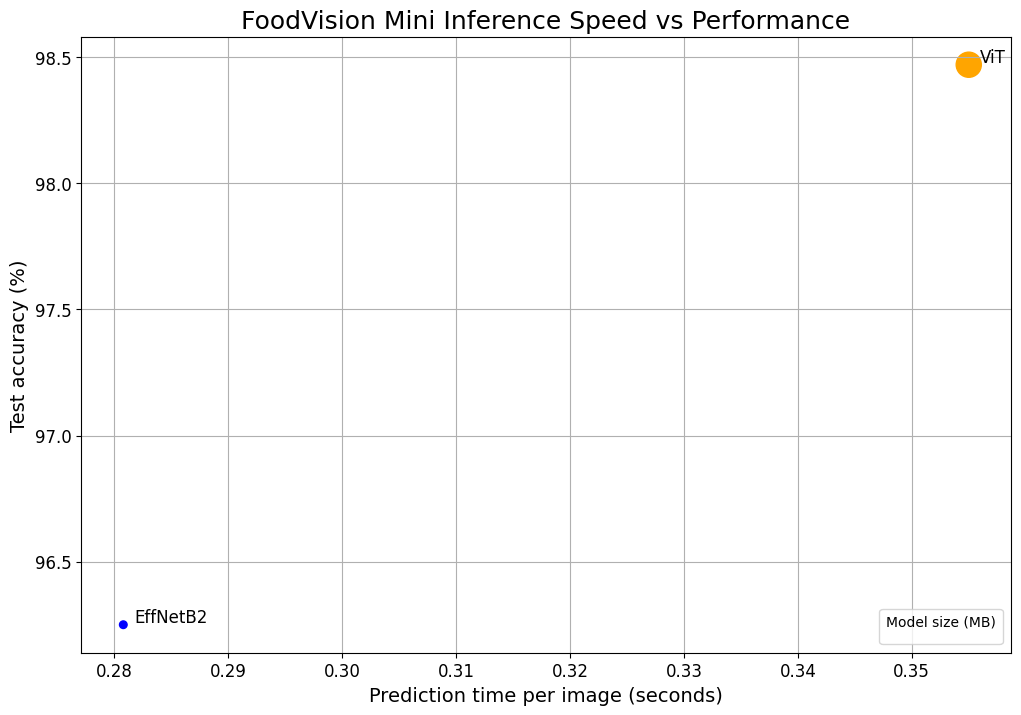

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.001, row["test_acc"] + 0.01),
                size=12)

handles, labels = scatter.legend_elements(prob="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("food_vision Mini inference speed vs performance.png")

In [23]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [24]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [25]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension#%% md

## 1. Getting Data

In [26]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision

    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular.
    !mv pytorch-deep-learning/helper_functions.py.  # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

data_20_percent_path

In [ ]:
# setup training and test path

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

## 2. FoodVision Mini model deployment experiment

## 3. EffNetB2

```import torchvision
# 1. setup pretrained effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()
# 3. setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="Default"
# 4. freeze the base layer in the model
for param in effnetb2.parameters():
    param.requires_grad = False
# 5. set classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [ ]:
def creat_effnetb2_model(num_classes: int = 3,
                         seed: int = 42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = creat_effnetb2_model(num_classes=3, seed=42)

In [ ]:
effnetb2_transforms

In [ ]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 test_transform=effnetb2_transforms,
                                                                                                 batch_size=32,
                                                                                                 num_workers=0)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

In [ ]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth")

Size

In [ ]:
from pathlib import Path

pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EFFNET_B2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)}MB")

Number of Parameters

In [ ]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

In [ ]:
effnetb2_state = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_state

# ViT Extractor

In [ ]:
vit = torchvision.models.vit_b_16()
vit.heads

In [ ]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

In [ ]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32,
                                                                                       num_workers=0)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

In [ ]:
device

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth")


In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path(
    "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)}MB")

In [ ]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

In [ ]:
vit_state = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_state

In [ ]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*"))
test_data_paths[:5]

In [ ]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    for path in tqdm(paths):
        pred_dict = {"image_path": path}
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            ent_time = timer()
            pred_dict["time_for_pred"] = round(ent_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list


In [ ]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


In [ ]:
effnetb2_test_pred_dicts[:2]

In [ ]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

In [ ]:
effnetb2_test_pred_df.correct.value_counts()

In [ ]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

In [ ]:
effnetb2_state["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_state

In [ ]:
ViT_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")
ViT_test_pred_df = pd.DataFrame(ViT_test_pred_dicts)


In [ ]:
ViT_test_pred_df.correct.value_counts()

In [ ]:
ViT_average_time_per_pred = round(ViT_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {ViT_average_time_per_pred}")

In [ ]:
vit_state["time_per_pred_cpu"] = ViT_average_time_per_pred
vit_state

In [ ]:
df = pd.DataFrame([effnetb2_state, vit_state])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

In [ ]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model")
                   .loc["EffNetB2"]), columns=["ViT to EffNetB2 ratios"]).T

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.001, row["test_acc"] + 0.01),
                size=12)

handles, labels = scatter.legend_elements(prob="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("food_vision Mini inference speed vs performance.png")

In [28]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [29]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [30]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time

In [33]:
import random
from PIL import Image
from timeit import timeit as timer

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_data_paths[0]

random_image_path = random.sample(test_data_paths, k=1)[0]
# random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\steak\1335842.jpg

{'pizza': 0.2543036937713623, 'steak': 0.6136661171913147, 'sushi': 0.13203024864196777}
0.0101


In [34]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\pizza\\3497151.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1335842.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\3177743.jpg']]

In [38]:
import gradio as gr

title = "FoodVision Mini😊"
description = "An [EffNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images as pizza, steak and sushi"
article = "Create at [09. PyTorch Model Deployment](http://keivanjamali.com)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://e007cf83c28fdf57c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\gradio\queueing.py", line 223, in push
    event_queue = self.event_queue_per_concurrency_id[event.concurrency_id]
                  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
KeyError: '2567189297440'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 407, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 